In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

In [3]:
data = pd.read_csv('/content/drive/MyDrive/DeepLearningProject/train.csv')

In [4]:
data.dropna(subset = ["text"], inplace=True)

In [5]:
df = data
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
3126,lol to see my king,neutral
10806,rainy season-- here it comes!,neutral
3977,aww sorry boo. I haven`t bought a printer in ...,neutral
16151,"...celebrated by spilling half my soup. Hello,...",neutral
1982,_2008 don`t be sorry you can race for charity...,positive


In [6]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,sentiment
3126,lol see king,neutral
10806,rainy season-- comes!,neutral
3977,aww sorry boo. haven`t bought printer years; c...,neutral
16151,"...celebrated spilling half soup. Hello, 40 ca...",neutral
1982,_2008 don`t sorry race charity fun. one fun.,positive


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.2, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 21984
# Test data samples: 5496


In [10]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 21984 documents
10000 words in dictionary
Top 5 most common words are: [('s', 2897), ('i', 2846), ('t', 2536), ('it', 1894), ('m', 1849)]


After having created the dictionary we can convert the text to a list of integer indexes. This is done with the text_to_sequences method of the Tokenizer.

In [11]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)


In [12]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

In [13]:
print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[106, 199, 12]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 3.0 features with a value of 1.


In [14]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [15]:
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"1" is converted into [0. 1. 0.]


In [16]:
print(X_train_oh.shape)

(21984, 10000)


In [17]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.2, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)
print('Shape of validation set:',X_train_rest.shape)

Shape of validation set: (4397, 10000)
Shape of validation set: (17587, 10000)


Baseline model We start with a model with 2 densely connected layers of 64 hidden elements. The input_shape for the first layer is equal to the number of words we allowed in the dictionary and for which we created one-hot-encoded features.

As we need to predict 3 different sentiment classes, the last layer has 3 hidden elements. The softmax activation function makes sure the three probabilities sum up to 1.

In the first layer we need to estimate 640064 weights. This is determined by (nb inputs * nb hidden elements) + nb bias terms, or (10000 x 64) + 64 = 640064 In the second layer we estimate (64 x 64) + 64 = 4160 weights In the last layer we estimate (64 x 3) + 3 = 195 weights

In [18]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [19]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [20]:
base_history = deep_model(base_model)

In [21]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

We can see here that the validation loss starts to increase as from epoch 4. The training loss continues to lower, which is normal as the model is trained to fit the train data as good as possible

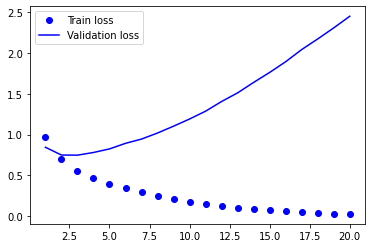

In [22]:
eval_metric(base_history, 'loss')

Just as with the validation loss, the validation accuracy peaks at an early epoch. After that, it goes down slightly. So to conclude, we can say that the model starts overfitting as from epoch 4

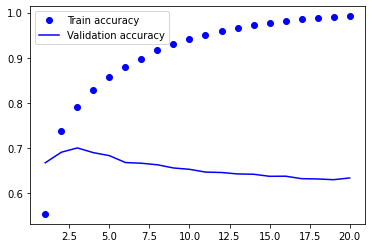

In [23]:
eval_metric(base_history, 'accuracy')

## Handling overfitting
Now, we can try to do something about the overfitting. There are different options to do that.

#### Option 1: reduce the network's size by removing layers or reducing the number of hidden elements in the layers

#### Option 2: add regularization, which comes down to adding a cost to the loss function for large weights

#### Option 3: adding dropout layers, which will randomly remove certain features by setting them to zero

Reducing the network's size We reduce the network's size by removing one layer and lowering the number of hidden elements in the remaining layer to 32.

In [24]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [25]:
reduced_history = deep_model(reduced_model)

In [26]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

We can see that it takes more epochs before the reduced model starts overfitting (around epoch 10). Moreover, the loss increases much slower after that epoch compared to the baseline model.

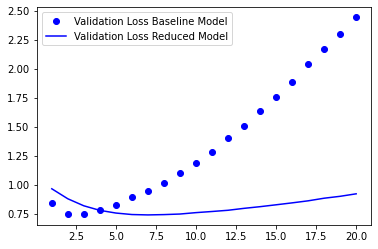

In [27]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

Adding regularization To address overfitting, we can also add regularization to the model. Let's try with L2 regularization

In [28]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [29]:
reg_history = deep_model(reg_model)

For the regularized model we notice that it starts overfitting earlier than the baseline model. However, the loss increases much slower afterwards.

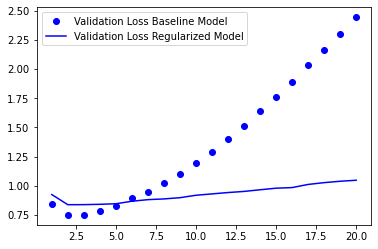

In [30]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

Adding dropout layers The last option we'll try is to add dropout layers.

In [31]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [32]:
drop_history = deep_model(drop_model)

The model with dropout layers starts overfitting a bit later than the baseline model. The loss also increases slower than the baseline model.

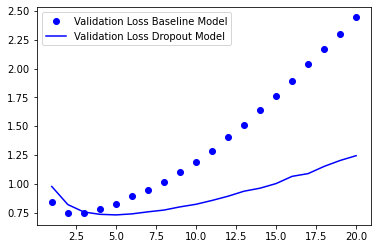

In [33]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

Training on the full train data and evaluation on test data At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [34]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [35]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

172/172 [==============================] - 0s 2ms/step - loss: 1.4392 - accuracy: 0.6530
/n
Test accuracy of baseline model: 65.30%


In [36]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

172/172 [==============================] - 0s 2ms/step - loss: 0.9723 - accuracy: 0.6758
/n
Test accuracy of reduced model: 67.58%


In [37]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

172/172 [==============================] - 0s 3ms/step - loss: 0.9905 - accuracy: 0.6983
/n
Test accuracy of regularized model: 69.83%


In [38]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

172/172 [==============================] - 0s 2ms/step - loss: 1.0773 - accuracy: 0.6843
/n
Test accuracy of dropout model: 68.43%
